In [1]:
# -*- coding: utf-8 -*-
"""
Application case of paper (Attention-based pattern discovery of mass spectrometry imaging data) code in colorectal adenocarcinoma.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
np.random.seed(1337)
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import torch
import pandas as pd
import time
import nibabel as nib
# ======= Directory Information:
Cd = os.getcwd()
Bd = os.path.dirname(Cd)

# ========= Color Map ==============                                      
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# ====== Visualize Image: From 1D vector to Image ==============
def Image_Distribution(V,xLoc,yLoc):
    col = max(np.unique(xLoc))
    row = max(np.unique(yLoc))
    Myimg = np.zeros((col,row))
    for i in range(len(xLoc)):
        Myimg[xLoc[i]-1, yLoc[i]-1] = V[i]
    return Myimg

# ================= Correlate Cluster with MSI Data =============
def Correlate_Cluster_MSI(cluster_id,Labels,MSI_D,Peak_Indx,ZCoord_cv,XCoord_cv,YCoord_cv):
    Kimg = Labels==cluster_id
    Kimg = Kimg.astype(int)
    MSI_CleanPeaks = MSI_D[:,Peak_Indx[:]]
    Corr_Val =  np.zeros(len(Peak_Indx))
    
    for i in range(len(Peak_Indx)):
        Corr_Val[i] = stats.pearsonr(Kimg,MSI_CleanPeaks[:,i])[0]
    id_mzCorr = np.argmax(Corr_Val)
    rank_ij =  np.argsort(Corr_Val)[::-1]
    return Corr_Val, rank_ij, MSI_CleanPeaks

# ========================== 3D mz image ============================
def Get_3Dmz_nifti(MSI_CleanPeaks,mz_Peak,XCoord_cv,YCoord_cv,ZCoord_cv,directory):
    mzSections = np.unique(ZCoord_cv)
    Vol_mz = np.zeros((200,200,len(mzSections)))
    nSections = len(mzSections)
    directory_NIFT = directory + '//mz_Vol//Training'
    if not os.path.exists(directory_NIFT):
        os.makedirs(directory_NIFT)
    for Zsec in range(len(mzSections)):
        ij_r = np.argwhere(ZCoord_cv == mzSections[Zsec])
        indx = ij_r[:,0]
        xLoc = XCoord_cv[indx]
        yLoc = YCoord_cv[indx]
        MSI_2D = np.squeeze(MSI_CleanPeaks[indx])
        for idx in range(len(xLoc)):
            Vol_mz[xLoc[idx]-1, yLoc[idx]-1,Zsec] = MSI_2D[idx]  

    I_nii = nib.Nifti1Image(Vol_mz,affine=np.eye(4))
    nib.save(I_nii,directory_NIFT +'//mz_' + str(mz_Peak) + '.nii')
#============= Spatial Distribution Encoded Fetaures =============
def get_EncFeatures(Latent_z,Train_idx,myZCoord,xLocation,yLocation,directory,order):
    myzSections = np.unique(myZCoord)
    ndim = Latent_z.shape[1]
    for zr in range(len(Train_idx)):
        ij_r = np.argwhere(myZCoord == myzSections[zr])
        indx = ij_r[:,0]
        xLoc = xLocation[indx]
        yLoc = yLocation[indx]
        zSection_Latent_z = np.squeeze(Latent_z[indx,])        
        plt.figure(figsize=(14, 14))
        for j in range(ndim):
            EncFeat = zSection_Latent_z[:,j] #encoded_imgs[i,0] #image index starts at 0 not 1 
            im = Image_Distribution(EncFeat,xLoc,yLoc);
            ax = plt.subplot(1, ndim, j + 1)    
            plt.imshow(im,cmap="hot");  # plt.colorbar()   
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        directory_Latz = directory+'//Latent//Training_'+str(order)
        if not os.path.exists(directory_Latz):
            os.makedirs(directory_Latz)
        plt.savefig(directory_Latz + '//EncFetaures_Tissue'+str(myzSections[zr])+'.png',bbox_inches='tight')
        
# ================== Get GMM Image for cv analysis ================        
def get_gmmImage(Train_idx,Features,nClusters,myZCoord,xLocation,yLocation,directory,order):
    myzSections = np.unique(myZCoord); Zsec=0; 
    C_imgs = np.zeros((200,200,len(range(1,len(Train_idx)+1,1)),nClusters))
    directoryGmm = directory+'//GMM//Training_'+str(order)
    if not os.path.exists(directoryGmm):
        os.makedirs(directoryGmm)
        
    for zr in range(len(Train_idx)):
        im = []
        ij_r = np.argwhere(myZCoord == myzSections[zr])
        indx = ij_r[:,0]
        xLoc = xLocation[indx]
        yLoc = yLocation[indx]
        zSection_labels = Features[indx]
        im = zSection_labels
        im = Image_Distribution(im,xLoc,yLoc);
        MyCmap = discrete_cmap(nClusters, 'jet')    
            
        plt.imshow(im,cmap=MyCmap);
        plt.colorbar(ticks=np.arange(0,nClusters,1))
        plt.axis('off')
        plt.title(f'zr={zr}')
        plt.show()        
        plt.imsave(directoryGmm + '//gmm_Training_'+str(myzSections[zr])+'_K_' + str(nClusters) + '.png',im,cmap=MyCmap)  

         # Save single clusters:
        directory_SingleC =directoryGmm + '//GMM_Section_'+str(myzSections[zr])
        if not os.path.exists(directory_SingleC):
            os.makedirs(directory_SingleC)
            
        for c in range(0,nClusters,1):
            cluster_id = c
            Kimg = zSection_labels[:]==cluster_id
            Kimg = Kimg.astype(int)
            for idx in range(len(xLoc)):
                C_imgs[xLoc[idx]-1, yLoc[idx]-1,Zsec,cluster_id] = Kimg[idx]  
            Kimg = Image_Distribution(Kimg,xLoc,yLoc);
            
            segCmp = [MyCmap(0),MyCmap(cluster_id)]
            segCmp[0]= (0,0,0)
            cm = LinearSegmentedColormap.from_list('Walid_cmp',segCmp,N=2)
            plt.imshow(Kimg, cmap=cm);
            plt.colorbar(ticks=np.arange(0,1,1))
            plt.axis('off')
            plt.show()
            plt.imsave(directory_SingleC + '//Cluster_' + str(cluster_id) + '.png',Kimg,cmap=cm)  
        Zsec +=1
    #Save NIFTI
    directory_NIFT = directoryGmm + '//NIFTI'
    if not os.path.exists(directory_NIFT):
        os.makedirs(directory_NIFT)
    for c in range(0,nClusters,1):
        I_nii = nib.Nifti1Image(C_imgs[:,:,:,c],affine=np.eye(4))
        nib.save(I_nii,directory_NIFT +'//Label_' + str(c) + '.nii')

# ======== Save NIFTI image for each cluster ==================
def Cluster_To_Nifti(directory,C_imgs,nClusters):
    directory_NIFT = directory + '//GMM_K'+str(nClusters)+'//NIFTI'
    if not os.path.exists(directory_NIFT):
        os.makedirs(directory_NIFT) 
    for c in range(1,nClusters+1,1):
        I_nii = nib.Nifti1Image(C_imgs[:,:,:,c],affine=np.eye(4))
        nib.save(I_nii,directory_NIFT +'//Label_' + str(c) + '.nii')
                  

/home/amfe/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


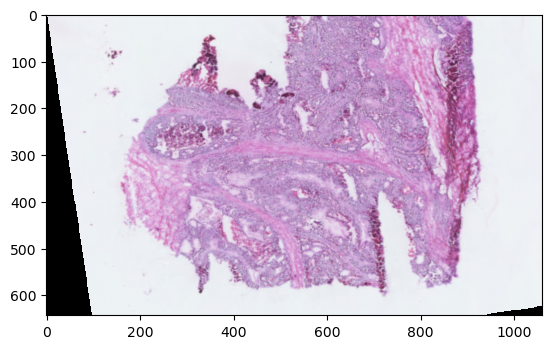

In [4]:
# The data are publicly available, see our paper for details.
f = h5py.File('./data/Colorectal_Adenocarcinoma.h5', 'r')
plt.imshow(np.array(f['data']['s26']['op']).transpose(1,2,0))

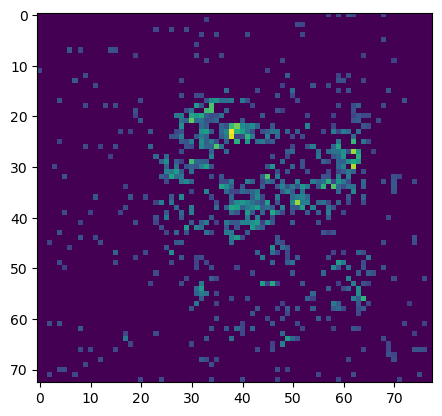

In [5]:
f=h5py.File('./data/Colorectal_Adenocarcinoma.h5','r')
test=np.array(f['data']['s1']['x'])
plt.imshow(test[49,:,:])
f.close()

In [2]:
f=h5py.File('./data/Colorectal_Adenocarcinoma.h5','r')
section_num=26
row=np.array(f['data']['s1']['x']).shape[-2]
col=np.array(f['data']['s1']['x']).shape[-1]
mzList=np.array(f['mz']).reshape(-1)
location=np.zeros(shape=(row*col*section_num,3),dtype=np.int16)
nSpecFeatures = len(mzList)
MSI_train=np.zeros(shape=(row*col*section_num,nSpecFeatures))
TissueIDs = [x for x in range(1,section_num+1,1)]

#for z in range(0,section_num,1):
index=0
for z in range(0,section_num,1):
    spec_data=np.array(f['data']['s'+str(z+1)]['x'])
    for x in range(0,row,1):
        for y in range (0,col,1):
            location[index]=[x,y,z]
            MSI_train[index]=spec_data[:,x,y]
            index+=1

Tic_sum=np.sum(MSI_train,axis=-1)
not_Zero_point=(Tic_sum!=0.)
location=location[not_Zero_point,:]
MSI_train=MSI_train[not_Zero_point,:]
Combined_MSI=(MSI_train/np.sum(MSI_train,axis=-1)[:,None]).astype(np.float32)
XCoord=location[:,0]
YCoord=location[:,1]
ZCoord=location[:,2]
f.close()

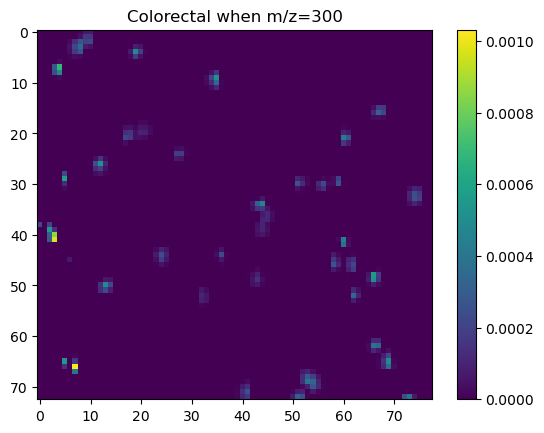

In [7]:
# 找mz值接近于6227.9的时候，用所有数据坐标和强度绘图
mzId = np.argmin(np.abs(mzList[:] - 500))
im = np.zeros((row,col))
for i in range(len(XCoord)):
    im[ XCoord[i], YCoord[i]] = Combined_MSI[i,mzId] #image index starts at 0 not 1
plt.imshow(im);plt.colorbar();plt.title('Colorectal when m/z=300')
plt.show()

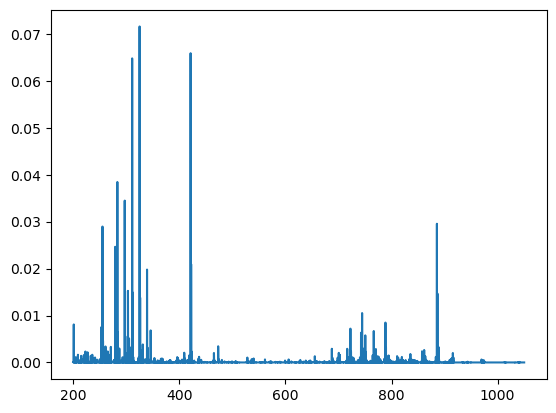

In [8]:
plt.plot(mzList,np.mean(Combined_MSI,axis=0))

Training: [ 1  2  3  6  7  8  9 11 13 14 15 16 17 18 19 20 21 23 24 25] Testing:[ 0  4  5 10 12 22]
Training: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 17 18 21 22 23 24 25] Testing:[ 3 15 16 19 20]
Training: [ 0  1  3  4  5  6  7  8  9 10 12 15 16 18 19 20 21 22 23 24 25] Testing:[ 2 11 13 14 17]
Training: [ 0  2  3  4  5  7  8 10 11 12 13 14 15 16 17 18 19 20 22 23 25] Testing:[ 1  6  9 21 24]
Training: [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 19 20 21 22 24] Testing:[ 7  8 18 23 25]


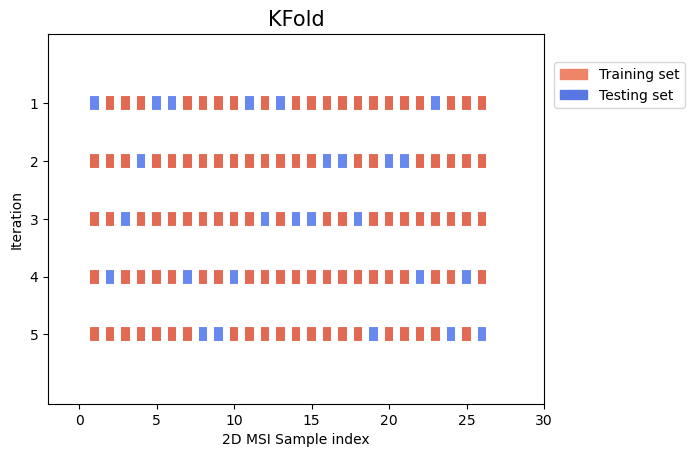

In [3]:


# ============ KFold Cross Validation:
from sklearn.model_selection import  KFold
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

n_folds = 5
kfold = KFold(n_folds,  shuffle=True) 
fig, ax = plt.subplots() 
ij_Training = []; ij_Testing = []
myHF = h5py.File('CV_Values//cv_Idx.h5', 'w')
for ij, (Train_idx, Test_idx) in enumerate(kfold.split(TissueIDs)):
    print("Training: %s Testing:%s" %(Train_idx, Test_idx))
    ij_Training.append(Train_idx)
    ij_Testing.append(Test_idx)
    myHF.create_dataset('indx_Training'+str(ij), data=Train_idx)
    myHF.create_dataset('indx_Testing'+str(ij), data=Test_idx)   
    
    indices = np.array([np.nan] * len(TissueIDs))
    indices[Train_idx] = 1
    indices[Test_idx] = 0
    # Visalize Corss Validation Behavior:
    ax.scatter(range(1,len(indices)+1), [ij + 1] * len(indices),
               c=indices, marker='_', lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    yticklabels = list(range(1,n_folds+1))
    ax.set(yticks=np.arange(1,n_folds+1) , yticklabels=yticklabels,
           xlabel='2D MSI Sample index', ylabel="Iteration",
           ylim=[n_folds+1.2,-.2], xlim=[-2, len(TissueIDs)+4])
    ax.set_title('KFold', fontsize=15)
ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.1))],
['Training set', 'Testing set'], loc=(1.02, .8))
myHF.close()


In [ ]:
import Computational_Model_trans
from Computational_Model_trans import *
from importlib import reload
reload(Computational_Model_trans)
# -------- A function to get training Data:
def Get_cv_MSI(Combined_MSI,XCoord,YCoord,ZCoord,zSections,CV_idx):
    ij_r=[]; ij_t=[]; MSI_train=[]; MSI_Test=[]
    # Get Training Data:
    for jr,zr in enumerate(CV_idx):        
        if jr==0:
            ij_r = np.argwhere(ZCoord == zSections[zr])
        else:
            ij_r = np.concatenate((ij_r, np.argwhere(ZCoord == zSections[zr])),axis=0)
    MSI_Data = np.squeeze(Combined_MSI[ij_r,])
    XCoord_cv = XCoord[ij_r]
    YCoord_cv = YCoord[ij_r]
    ZCoord_cv = ZCoord[ij_r]

    return MSI_Data,XCoord_cv,YCoord_cv,ZCoord_cv

# ------------------- Train and Test with CV:
zSections = np.unique(ZCoord)
directory = Cd+'/Results_CV'         
meanSpec_Orig_AllData = np.mean(Combined_MSI,axis=0)

# --------- Train model status:
TrainStatus =  int(input("Would you like to Train Your Model? Yes=1; No=0 ... :"))
if TrainStatus== 0:
    print('No Training')
else:
    print('Model Training ...>>>......')
hf_cv = h5py.File('CV_Values/cv_Idx.h5', 'r') 
ALL_Peaks_Train=None
for i in range(1):
    Train_idx = hf_cv['indx_Training'+str(i)][:]
    #Test_idx = hf_cv['indx_Testing'+str(i)][:]
    MSI_train,XCoord_cv,YCoord_cv,ZCoord_cv = Get_cv_MSI(Combined_MSI,XCoord,YCoord,ZCoord,zSections,Train_idx)
    #(MSI_train,XCoord_cv,YCoord_cv,ZCoord_cv) =(Combined_MSI,XCoord,YCoord,ZCoord)
	#MSI_Test,XCoord_cv,YCoord_cv,ZCoord_cv = Get_cv_MSI(Combined_MSI,XCoord,YCoord,ZCoord,zSections,Test_idx)
    myzSections = np.unique(ZCoord_cv)
# ************************* Training **************************************    
    # 1. ====== Initialize the model:

    input_shape = (nSpecFeatures, )
    intermediate_dim = 512
    latent_dim = 5
    batchsize=128
    d_model=256
    All_dataset=MSIdataset(MSI_train,XCoord_cv,YCoord_cv)
    train_dataloader = torch.utils.data.DataLoader(All_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=8)
    loss_function=categorical_crossentropy
    max_lr=0.1
    model=Model_trnas(d_mz=len(mzList),d_model=d_model,encoder_layer_num=1,decoder_layer_num=2)
    
    optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=0.01)
    if TrainStatus==0:
        model.load_state_dict(torch.load('TrainedModel_3DColorectal_trans.h5'))
    if TrainStatus==1:
        for epoch in range(10):
            time1=time.time()
            loss_in_epoch=[]
            for i,(data,xLoc,yLoc) in enumerate(train_dataloader):
                model.train()
                loss=loss_function(model(data),data)
                print(f'Epoch: {epoch} step: {i} loss:{loss.item()}')
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_in_epoch.append(loss.item())
                model.loss.append(loss.item())
            time2=time.time()
            print(f'avg loss in epoch {epoch}:{np.mean(loss_in_epoch)}')
            #if epoch%4==1:
                #torch.save(model.state_dict(),'TrainedModel_3DColorectal_trans.h5')
            #print(f'Epoch:{epoch} Loss:{loss.item()} Time/epoch:{(time2-time1)}s')
        model.eval()
        #torch.save(model.state_dict(),'TrainedModel_3DColorectal_trans.h5')
    encoder=nn.Sequential(model.backbone,model.transformerencoder)
    encoder.eval()
    decoded_imgs=torch.zeros_like(torch.tensor(MSI_train))
    Latent_z=torch.zeros(size=(MSI_train.shape[0],d_model))
    test_dataloader=torch.utils.data.DataLoader(All_dataset, batch_size=batchsize,
                                          shuffle=False, num_workers=8)
    for i,(data,xLoc,yLoc) in enumerate(test_dataloader):
            decoded_imgs[i*batchsize:i*batchsize+data.shape[0]]=model(data)
            Latent_z[i*batchsize:i*batchsize+data.shape[0]]=encoder(data)
    # 4. ============= Plot Average Spectrum:
    mse = nn.MSELoss(reduction='mean')(torch.tensor(MSI_train),decoded_imgs)
    meanSpec_Rec = torch.mean(decoded_imgs,dim=0) 
    print('mean squared error(mse)  = ', mse.item())
    meanSpec_Orig = torch.mean(torch.tensor(MSI_train),dim=0) # TIC-norm original MSI Data
    plt.plot(mzList,meanSpec_Orig.detach().numpy(),label='Original'); plt.plot(mzList,meanSpec_Rec.detach().numpy(),color = [1.0, 0.5, 0.25],label='Predicted'); 
    plt.title('TIC-norm distribution of average spectrum: Original and Predicted')
    plt.xlabel('m/z value');plt.ylabel('average intensity')
    plt.legend()
    plt.show()
    index=[0,10,128,300,1345,4990,6578,8067]
    fig,axes=plt.subplots(nrows=2,ncols=len(index),sharey=False)
    for id,num in enumerate(index):
        axes[0,id].plot(mzList,MSI_train[num])
    for id,num in enumerate(index):
        axes[1,id].plot(mzList,decoded_imgs[num].detach().numpy())
    
    nClusters = 5
    gmm = GaussianMixture(n_components=nClusters,random_state=0).fit(np.squeeze(Latent_z.detach().numpy()))
    Labels = gmm.predict(np.squeeze(Latent_z.detach().numpy()))+1
    myzSections = np.unique(ZCoord_cv)     
    zr=0
    ij_r = np.argwhere(ZCoord_cv == myzSections[zr])
    indx = ij_r[:,0]
    plt.figure()
    plt.imshow(Image_Distribution(Labels[indx],XCoord_cv[indx],YCoord_cv[indx]))
    plt.title(f'Section {myzSections[zr]}')
    plt.colorbar(ticks=np.arange(0,nClusters+1,1))
    plt.axis('off')
    plt.show()
    cluster_id =int(input())
    Kimg= Labels[indx]==cluster_id
    Kimg = Kimg.astype(int)
    plt.figure()
    plt.imshow(Image_Distribution(Kimg,XCoord_cv[indx],YCoord_cv[indx]))
    plt.axis('off')
    plt.show()
    Real_PeakIdx=np.arange(len(mzList))
    Learned_mzPeaks=mzList
    Corr_Val, CorrRank_ij,MSI_CleanPeaks =  Correlate_Cluster_MSI(cluster_id,Labels,MSI_train,Real_PeakIdx,ZCoord_cv,XCoord_cv,YCoord_cv)

    print('m/z', Learned_mzPeaks[CorrRank_ij[0:15]])
    print('corr_Value = ', Corr_Val[CorrRank_ij[0:15]])
    plt.plot(Learned_mzPeaks,Corr_Val)
    plt.show()
    if ALL_Peaks_Train==None:
        ALL_Peaks_Train=Learned_mzPeaks[CorrRank_ij[0:15]]
    else:
        ALL_Peaks_Train.append(Learned_mzPeaks[CorrRank_ij[0:15]])
hf_cv.close()



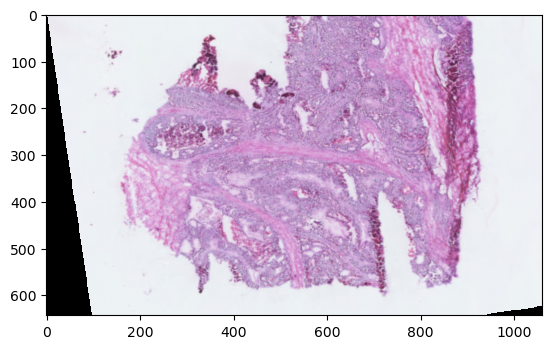

(-0.5, 76.5, 71.5, -0.5)

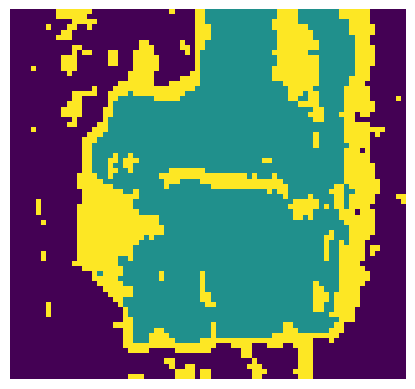

In [ ]:
zr=25
f=h5py.File('./data/Colorectal_Adenocarcinoma.h5','r')
plt.imshow(np.array(f['data']['s'+str(zr+1)]['op']).transpose(1,2,0))
plt.show()
f.close()
#compute a layer
cluster_id1 = 2
cluster_id2 = 5
myzSections = np.unique(ZCoord_cv)     

ij_r = np.argwhere(ZCoord_cv == myzSections[zr])
indx = ij_r[:,0]
Kimg1 = Labels[indx]==cluster_id1
Kimg1 = Kimg1.astype(int)
Kimg2 = Labels[indx]==cluster_id2
Kimg2 = 2*(Kimg2.astype(int))
Kimg=Kimg1+Kimg2
plt.imshow(Image_Distribution(Kimg,XCoord_cv[indx],YCoord_cv[indx]))
plt.axis('off')
# MSI_CleanPeaks = MSI_train[:,Real_PeakIdx[:]]
# MSI_CleanPeaks = MSI_CleanPeaks[indx[:]]
# Corr_Val =  np.zeros(len(Real_PeakIdx))

# for i in range(len(Real_PeakIdx)):
#     Corr_Val[i] = stats.pearsonr(Kimg,MSI_CleanPeaks[:,i])[0]
# id_mzCorr = np.argmax(Corr_Val)
# rank_ij =  np.argsort(Corr_Val)[::-1]
# print('m/z', Learned_mzPeaks[rank_ij[0:5]])
# print('corr_Value = ', Corr_Val[rank_ij[0:5]])
# plt.plot(Learned_mzPeaks,Corr_Val)

m/z [858.5260627  743.54559925 857.52606998 740.52552122 862.55613338
 742.5356066  280.23357012 861.54614073 279.2335774  717.52548856
 889.57613679 720.49546695 724.51553771 888.56624414 773.43568178]
corr_Value =  [0.80015372 0.7856085  0.78216291 0.78115499 0.77866219 0.77751194
 0.7726752  0.76810789 0.76379731 0.76211997 0.76034168 0.75943891
 0.75860979 0.75779724 0.75379957]


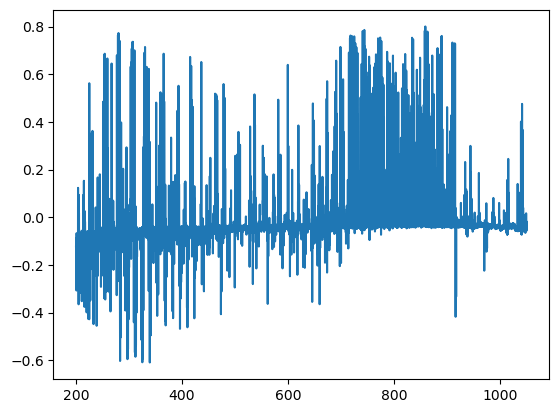

In [ ]:

# 7. ========== Correlate Clusters with MSI Data:
cluster_id = 2
Real_PeakIdx=np.arange(len(mzList))
Learned_mzPeaks=mzList
Corr_Val, CorrRank_ij,MSI_CleanPeaks =  Correlate_Cluster_MSI(cluster_id,Labels,MSI_train,Real_PeakIdx,ZCoord_cv,XCoord_cv,YCoord_cv)

print('m/z', Learned_mzPeaks[CorrRank_ij[0:15]])
print('corr_Value = ', Corr_Val[CorrRank_ij[0:15]])
plt.plot(Learned_mzPeaks,Corr_Val)

m/z Peak =  279.23357739656444


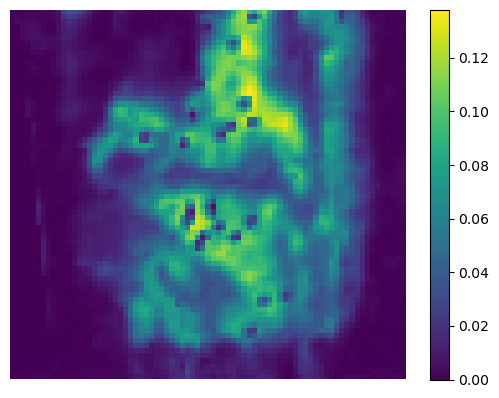

In [ ]:

# Visualize Correlated Peak at section z: 
mzID = CorrRank_ij[8];
myzSections = np.unique(ZCoord_cv)     
zr=25
ij_r = np.argwhere(ZCoord_cv == myzSections[zr])
indx = ij_r[:,0]
xLoc = XCoord_cv[indx]
yLoc = YCoord_cv[indx]
MSI_2D = np.squeeze(MSI_CleanPeaks[indx,mzID])
im_mz = Image_Distribution(MSI_2D,xLoc,yLoc);
plt.imshow(im_mz);plt.axis('off');plt.colorbar()
mz_Peak = Learned_mzPeaks[mzID]
print('m/z Peak = ',mz_Peak)



In [ ]:

# ============ Get 3D m/z image =================
mzValue = 13972.1
mzId = np.argmin(np.abs(mzList[:] - mzValue))
Get_3Dmz_nifti(Combined_MSI[:,mzId],mzValue,XCoord,YCoord,ZCoord,directory)


In [ ]:

# ============== Load Peak Learned by All training models:
myBeta = 1.5
ALL_Peaks_Train = np.squeeze(np.asarray(ALL_Peaks_Train))
ALL_Peaks_Train = np.nan_to_num(ALL_Peaks_Train)

My_marker= ['v', '*','d','^','s']
Point_Color = plt.cm.jet(np.linspace(0, 1, ALL_Peaks_Train.shape[1]))
plt.figure(figsize=(25, 5))
plt.plot(mzList,meanSpec_Orig_AllData,linewidth=3,c='black'); 
for ij in range(ALL_Peaks_Train.shape[1]):
    Peaks_Train = ALL_Peaks_Train[:,ij]
    Peaks_Train = Peaks_Train[Peaks_Train !=0]
    Train_Peaks_Loc = [np.argmin(np.abs(mzList[:] - Peaks_Train[idx])) for idx in  range(len(Peaks_Train))]
    Mean_PickedPeakst = np.mean(Combined_MSI[:,Train_Peaks_Loc],axis=0)
    plt.scatter(Peaks_Train,Mean_PickedPeakst,marker=My_marker[ij],c=Point_Color[ij]);


Peaks_Vector = ALL_Peaks_Train.reshape(ALL_Peaks_Train.shape[0]*ALL_Peaks_Train.shape[1])
Peaks_Vector_NoZero = Peaks_Vector[Peaks_Vector !=0]
U_Peaks = np.unique(Peaks_Vector_NoZero)
L = len(np.unique(U_Peaks))
#plt.figure(figsize=(20, 5))
n, bins, patches = plt.hist(x=Peaks_Vector_NoZero, bins=U_Peaks); plt.show()


In [ ]:

#=== Scatter Plot Frequency:
from matplotlib.ticker import MaxNLocator
New_n = np.append(n,1)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#plt.figure(figsize=(30, 5))
plt.scatter(U_Peaks,New_n,c=New_n)
plt.xlabel("m/z")
plt.ylabel("Frequency")

# ====== Bar Plot: Counts of Peak Frequency
N_Freq = [len(np.argwhere(n==ij)) for ij in np.unique(n)]
xValue = [ij for ij in np.unique(n)]
colors = plt.cm.jet(np.linspace(0, 1, len(np.unique(n))))
plt.bar(xValue, N_Freq,color=colors)
plt.xlabel("Frequency")
plt.ylabel("Count")



## draw 26 section: 2 cluster of interest

In [5]:

from Computational_Model_trans import *
model=Model_trnas(d_mz=len(mzList),d_model=d_model,encoder_layer_num=1,decoder_layer_num=2,n_head=n_head)
model.load_state_dict(torch.load('TrainedModel_3DColorectal_trans4.h5'))
encoder=nn.Sequential(model.backbone,model.transformerencoder)
model.eval()
encoder.eval()
All_dataset=MSIdataset(Combined_MSI,XCoord,YCoord,ZCoord)
All_dataloader = torch.utils.data.DataLoader(All_dataset , batch_size=batchsize,
                                          shuffle=False, num_workers=8)
                                          
with torch.no_grad():
    encode_feature=torch.zeros(size=(Combined_MSI.shape[0],d_model))
    X=torch.zeros(XCoord.shape,dtype=torch.int)
    Y=torch.zeros(YCoord.shape,dtype=torch.int)
    Z=torch.zeros(ZCoord.shape,dtype=torch.int)
    Combined_MSI_Shuffle=torch.zeros(size=(Combined_MSI.shape))
    decoded_imgs=torch.zeros(size=Combined_MSI.shape)
    for i,(data,xLoc,yLoc,zLoc) in enumerate(All_dataloader):
        encode_feature[i*batchsize:i*batchsize+data.shape[0]]=encoder(data)
        decoded_imgs[i*batchsize:i*batchsize+data.shape[0]]=model(data)
        X[i*batchsize:i*batchsize+data.shape[0]]=xLoc
        Y[i*batchsize:i*batchsize+data.shape[0]]=yLoc
        Z[i*batchsize:i*batchsize+data.shape[0]]=zLoc
        Combined_MSI_Shuffle[i*batchsize:i*batchsize+data.shape[0]]=data
    nClusters = 5
    gmm = GaussianMixture(n_components=nClusters,random_state=0).fit(np.squeeze(encode_feature.detach().numpy()))
    Labels = gmm.predict(np.squeeze(encode_feature.detach().numpy()))+1           

/home/amfe/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


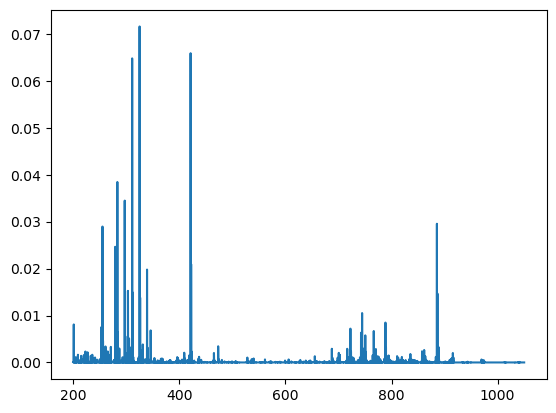

In [7]:
plt.plot(mzList,Combined_MSI.mean(axis=0))

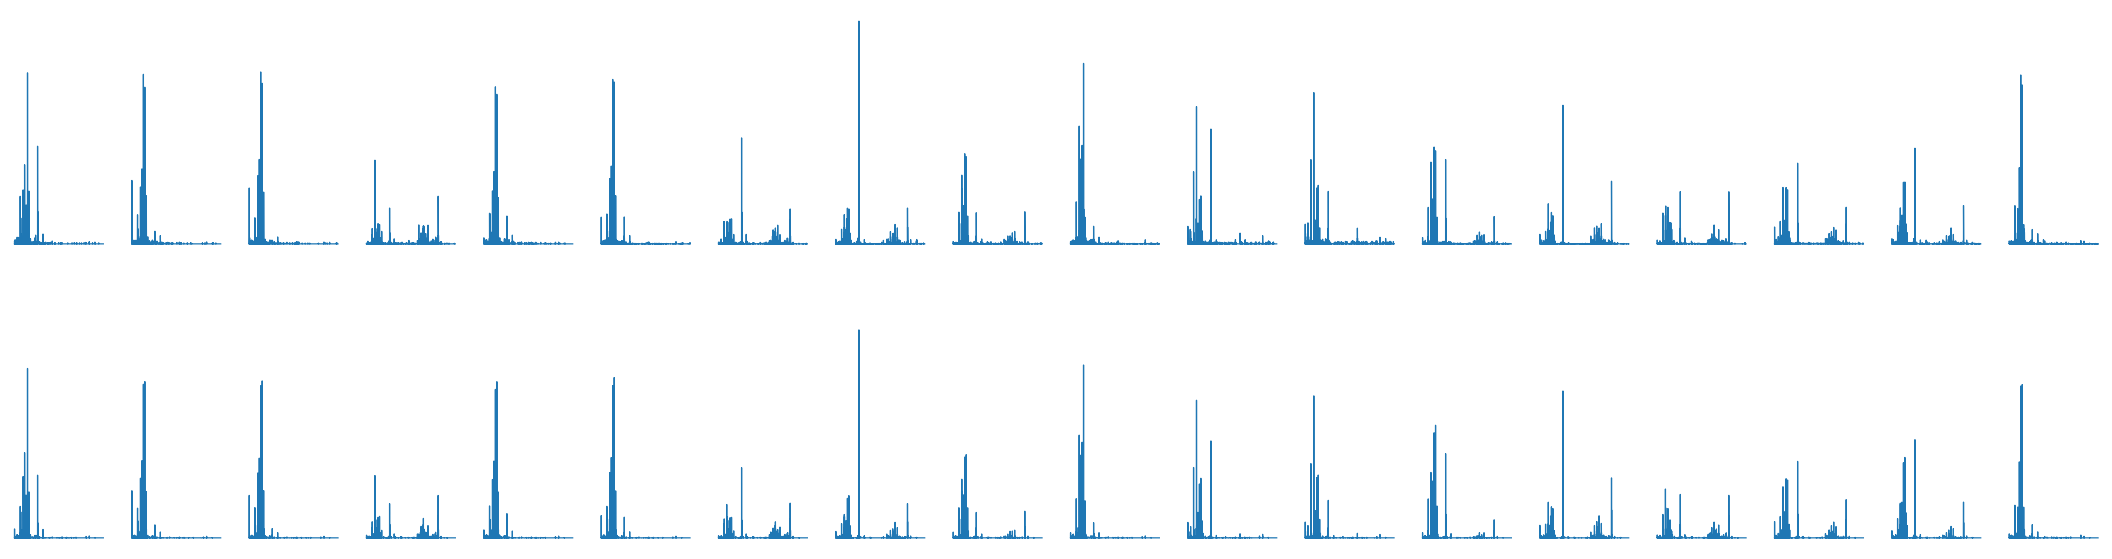

In [186]:
index=[0,50,500,1000,5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,115000,122400]
fig,axes=plt.subplots(nrows=2,ncols=len(index),sharey=True,figsize=(27, 7))
for id,num in enumerate(index):
    axes[0,id].plot(mzList,Combined_MSI[num],linewidth=0.9)
    if id!=0:
        axes[0,id].set_yticks([])
    axes[0,id].set_xticks([])
    axes[0,id].spines['top'].set_visible(False)
    axes[0,id].spines['right'].set_visible(False)
    axes[0,id].spines['bottom'].set_visible(False)
    axes[0,id].spines['left'].set_visible(False)
for id,num in enumerate(index):
    axes[1,id].plot(mzList,decoded_imgs[num].detach().numpy(),linewidth=0.9)
    if id!=0:
        axes[1,id].set_yticks([])
    axes[1,id].set_xticks([])
    axes[1,id].spines['top'].set_visible(False)
    axes[1,id].spines['right'].set_visible(False)
    axes[1,id].spines['bottom'].set_visible(False)
    axes[1,id].spines['left'].set_visible(False)

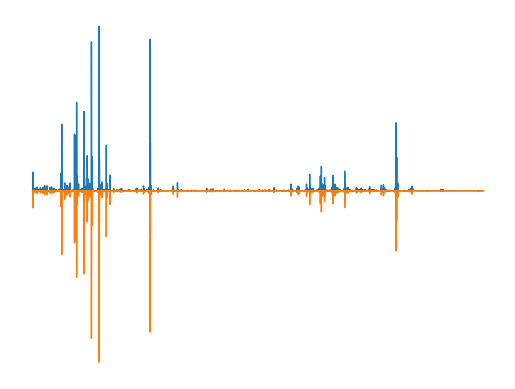

In [114]:
plt.plot(mzList,Combined_MSI.mean(axis=0),linewidth=1)
plt.plot(mzList,-decoded_imgs.mean(axis=0).detach().numpy(),linewidth=1)
plt.axis(False)
plt.savefig('Template/pic/colorectal/ori_pre.png',bbox_inches='tight',dpi=1000)  

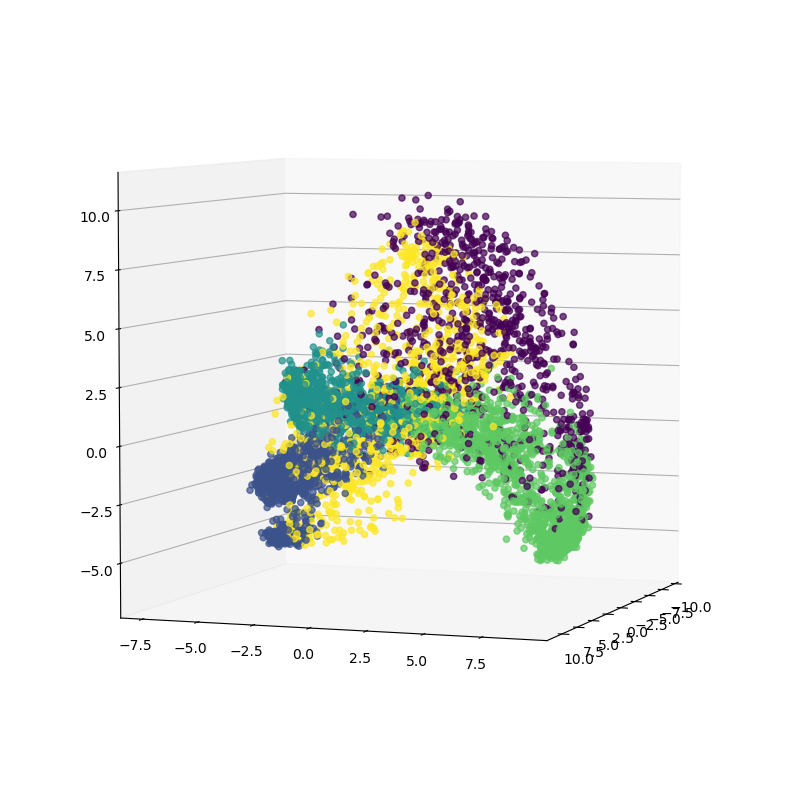

In [140]:
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
pca = PCA(n_components=3)
encode_feature_pca = pca.fit_transform(encode_feature[::20])
# distances = pairwise_distances(encode_feature_pca,Y=)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.grid(False)
ax.view_init(5,20)
ax.w_xaxis.gridlines.set_visible(False)
ax.w_yaxis.gridlines.set_visible(False)
# 绘制散点图，颜色表示聚类结果，大小表示欧式距离
ax.scatter(encode_feature_pca[:, 0], encode_feature_pca[:, 1], encode_feature_pca[:, 2], c=Labels[::20], alpha=0.7)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

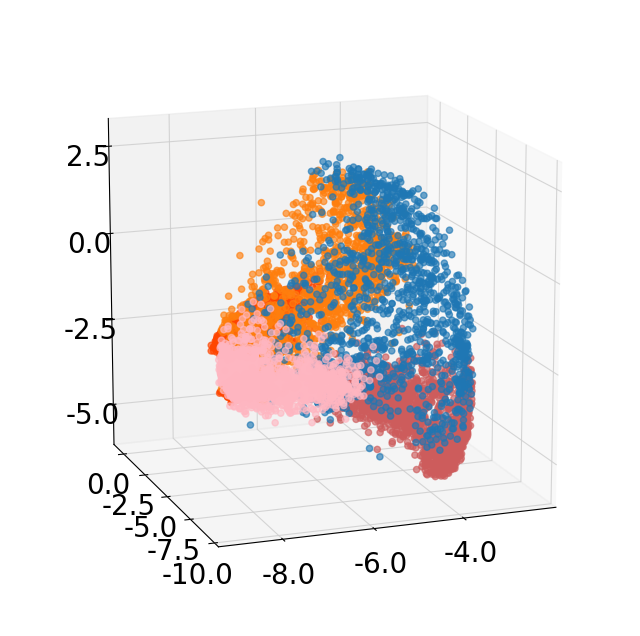

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
import random
# 假设encode_feature和Labels是你的数据
# encode_feature是一个高维数据集，每一行是一个样本
# Labels是对样本进行聚类后得到的类别标签

# 使用PCA进行降维，将高维数据转换为三维数据
pca = PCA(n_components=3)
encode_feature_pca = pca.fit_transform(encode_feature[::14])

# 创建3D图形
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，颜色表示聚类结果
# 如果Labels是整数型，可以用离散的颜色映射
unique_labels = np.unique(Labels[::14])
colors = plt.cm.tab10.colors  # 使用tab20配色方案，有20种不同颜色可供选择
colors = [[1,127/255,14/255],[1.0, 0.713, 0.757],[0.804, 0.361, 0.361],[1.0, 0.271, 0.0],[31/255,119/255,180/255] ]
for i, label in enumerate(unique_labels):
    mask = Labels[::14] == label
    ax.scatter(encode_feature_pca[mask, 1], encode_feature_pca[mask, 0], encode_feature_pca[mask, 2],marker=markers,
               c=colors[ i % (len(colors))], alpha=0.65)
    # if cluster_name!=None:
    #     ax.text(encode_feature_pca[mask, 1].mean(), encode_feature_pca[mask, 0].mean(),encode_feature_pca[mask, 2].mean() ,cluster_name,
    #             fontsize=50, color=colors[i+3 % len(colors)], ha='center', va='center')


# 设置侧边网格的显示
# ax.grid(True, which='both', axis='both', linestyle='--', color='red')

# 去掉底部网格的显示

xticks = ax.get_xticks()
yticks = ax.get_yticks()
zticks = ax.get_zticks()

# 设置X轴和Y轴刻度数字的大小
ax.set_xticklabels(xticks, fontsize=20)
ax.set_yticklabels(yticks, fontsize=20)
ax.set_zticklabels(zticks, fontsize=20)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
ax.xaxis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 0.8)
ax.yaxis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 0.8)
ax.zaxis._axinfo["grid"]["color"] = (0.8, 0.8, 0.8, 0.8)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='z', nbins=5)
# 设置视角的旋转角度
ax.view_init(elev=15, azim=-110)
plt.savefig('Template/pic/colorectal/scatter.png',bbox_inches='tight',dpi=1000)


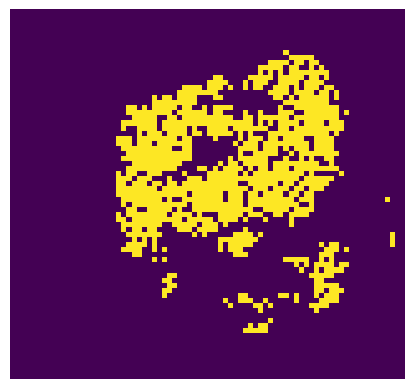

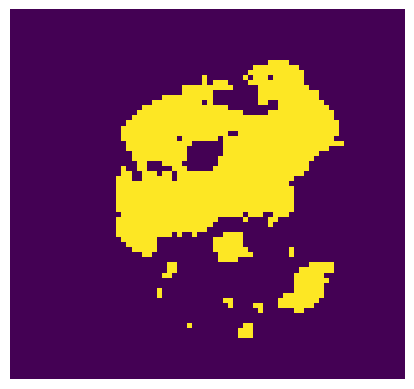

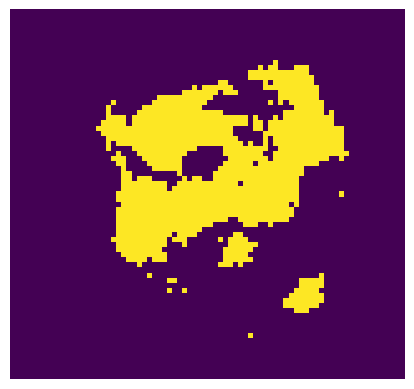

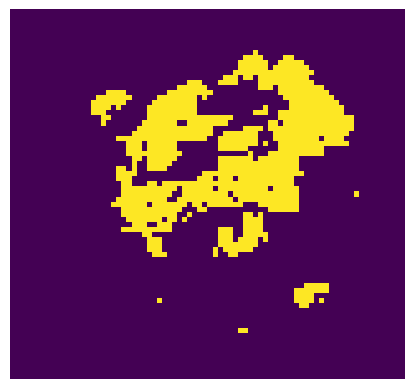

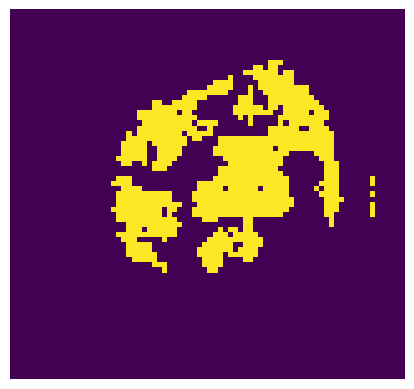

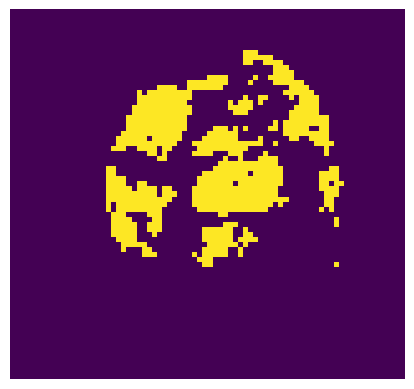

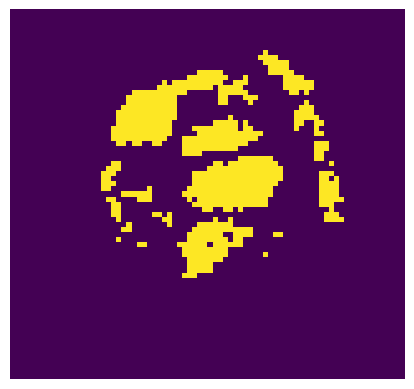

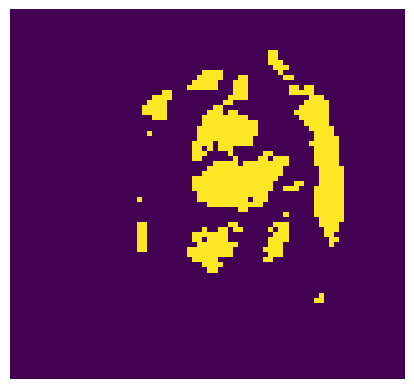

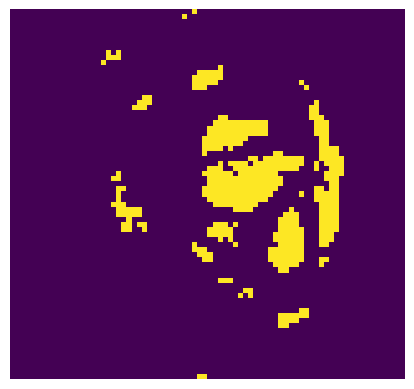

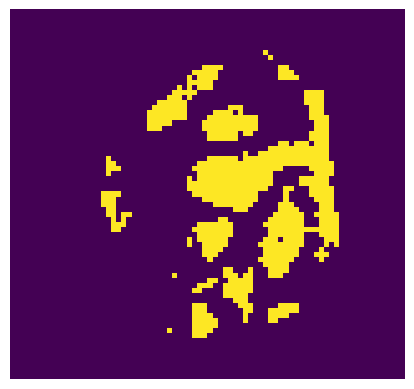

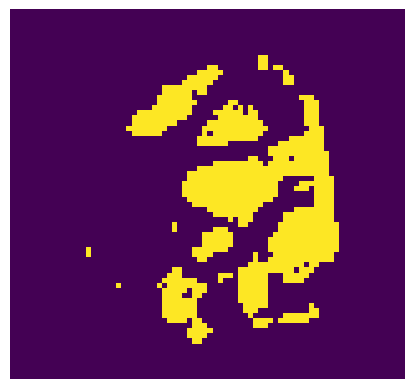

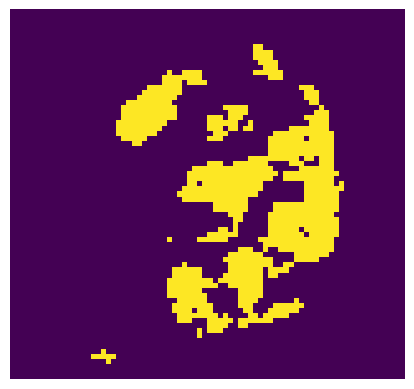

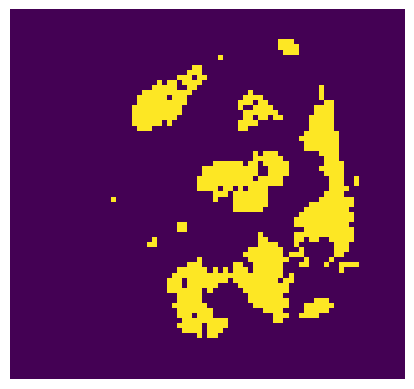

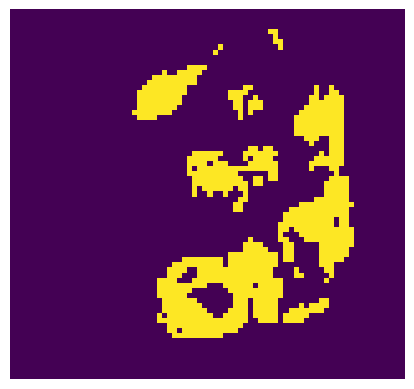

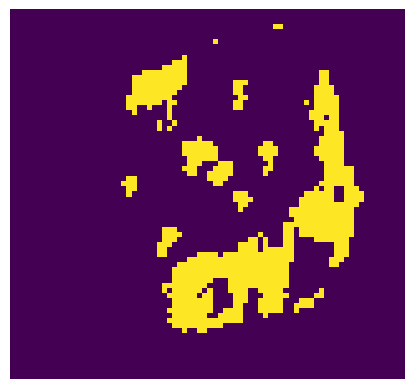

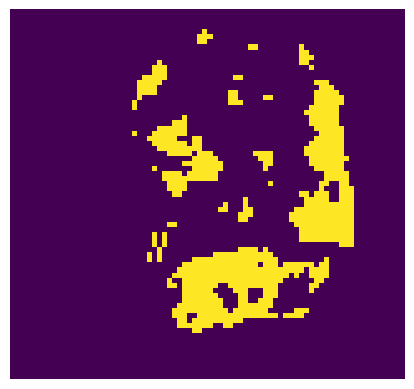

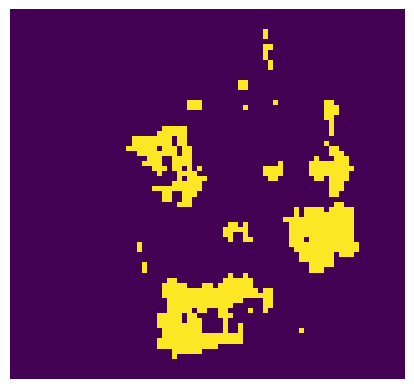

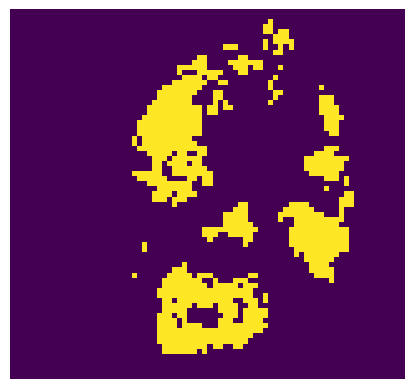

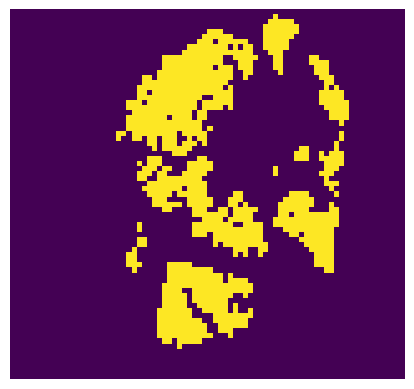

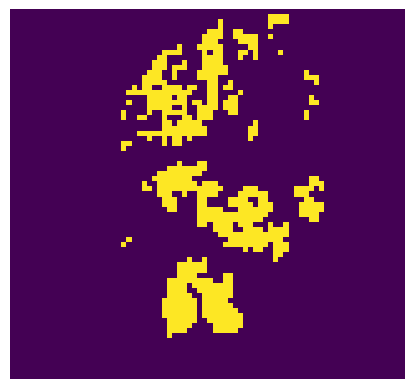

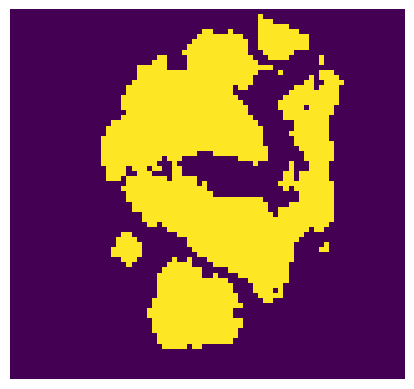

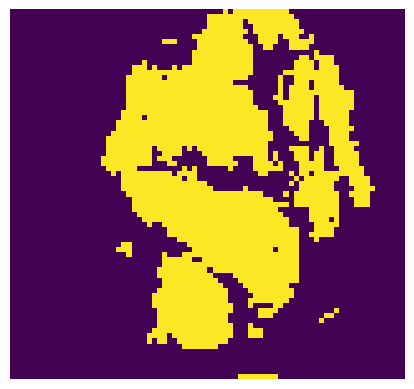

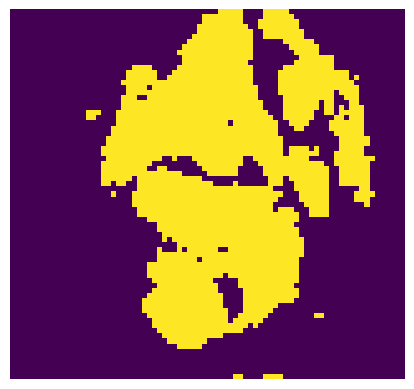

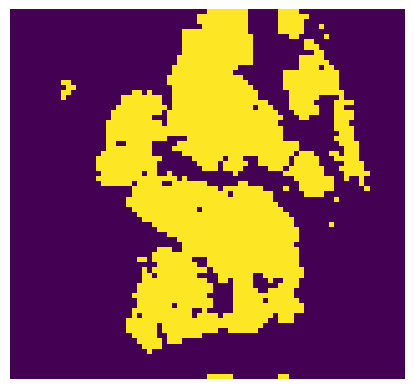

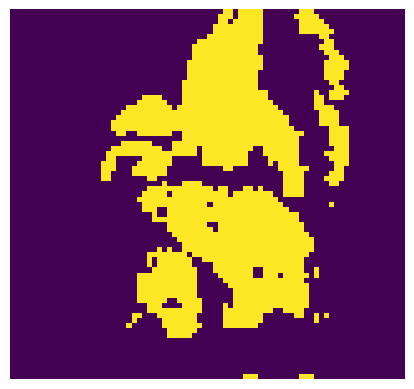

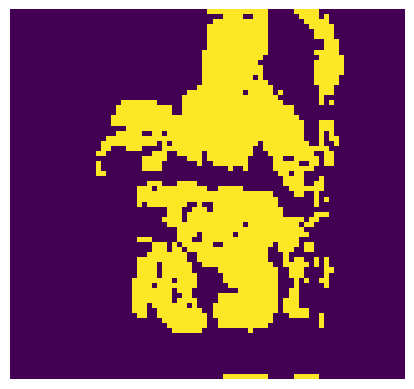

In [33]:
def Image_Distribution_row_col(V,xLoc,yLoc,row,col):
    Myimg = np.zeros((col,row))
    for i in range(len(xLoc)):
        Myimg[xLoc[i]-1, yLoc[i]-1] = V[i]
    return Myimg
cluster_id=[0,0]
cluster_id[0] = 3
cluster_id[1] = 6
myzSections = np.unique(Z) 
for section_id in myzSections:
    ij_r = np.argwhere(Z.detach().numpy() == section_id)
    indx = ij_r[:,0]
    Kimg=[0,0]
    Kimg[0] = Labels[indx]==cluster_id[0]
    Kimg[0] = Kimg[0].astype(int)
    Kimg[1] = Labels[indx]==cluster_id[1]
    Kimg[1] = 2*(Kimg[1].astype(int))
    Kimg_all=Kimg[0]+Kimg[1]
    plt.imshow(Image_Distribution_row_col(Kimg_all,X[indx],Y[indx],col,row))
    plt.axis('off')
    plt.show()
    #plt.imsave('achemso/pic/coloractal/s' + str(section_id+1)+'_cluster.png',Image_Distribution_row_col(Kimg_all,X[indx],Y[indx],col,row))  

In [31]:
ALL_Peaks_correlated

[array([-0.08587204, -0.07460321, -0.07291267, ..., -0.0271261 ,
        -0.03777399, -0.03161397]),
 array([-0.09742778, -0.07778213, -0.07557979, ..., -0.03121028,
        -0.03958092, -0.03478062]),
 array([-0.10856453, -0.0851157 , -0.08228991, ..., -0.03255976,
        -0.04089231, -0.0358177 ]),
 array([-0.10069943, -0.08058232, -0.07810379, ..., -0.03111403,
        -0.04005878, -0.03443781])]

m/z [200.17325261 200.27325188 200.39315101 200.48815032 200.58314963
 200.69324882 200.80819799 200.92314715 201.03324635 201.13324562
 201.21324504 201.25324475 201.32324424 201.3832438  201.49819297
 201.61314213 201.70319148 201.79324082 201.9332398  202.043239
 202.14323827 202.21323777 202.34323682 202.43323616 202.52323551
 202.60323493 202.75323384 202.83823322 202.9232326  203.02323187
 203.143231   203.2532302  203.3632294  203.48322853 203.59322772
 203.68322707 203.77322642 203.90322547 204.00322474 204.11322394
 204.22322314 204.38322198 204.44322154 204.51322103 204.65322001
 204.81321885 204.93321798 205.03321725 205.14321645 205.29321536
 205.42321441 205.54321354 205.63321288 205.76321194 205.90321092
 206.00321019 206.12330932 206.21330866 206.2632083  206.34320772
 206.38320743 206.4832067  206.5932059  206.67320532 206.75320473
 206.90320364 207.00320292 207.1432019  207.28320088 207.40320001
 207.5131992  207.6231984  207.66329811 207.81319702 207.88319651
 207.993

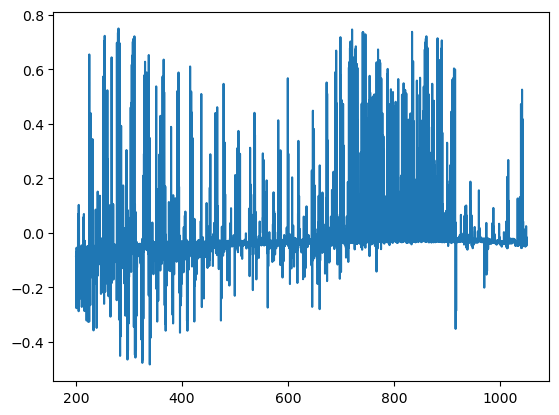

In [34]:
def Image_Distribution_row_col(V,xLoc,yLoc,row,col):
    Myimg = np.zeros((col,row))
    for i in range(len(xLoc)):
        Myimg[xLoc[i]-1, yLoc[i]-1] = V[i]
    return Myimg
selected_cluster=3
myzSections = np.unique(Z) 
Real_PeakIdx=np.arange(len(mzList))
Learned_mzPeaks=mzList
Corr_Val, CorrRank_ij,MSI_CleanPeaks =  \
Correlate_Cluster_MSI(selected_cluster,Labels,Combined_MSI_Shuffle,Real_PeakIdx,Z,X,Y)
print('m/z', Learned_mzPeaks[0:100])
print('corr_Value = ', Corr_Val[0:100])
ALL_Peaks_correlated.append(Corr_Val[:])
plt.plot(Learned_mzPeaks,Corr_Val)
plt.show()
mzID = CorrRank_ij[0];  


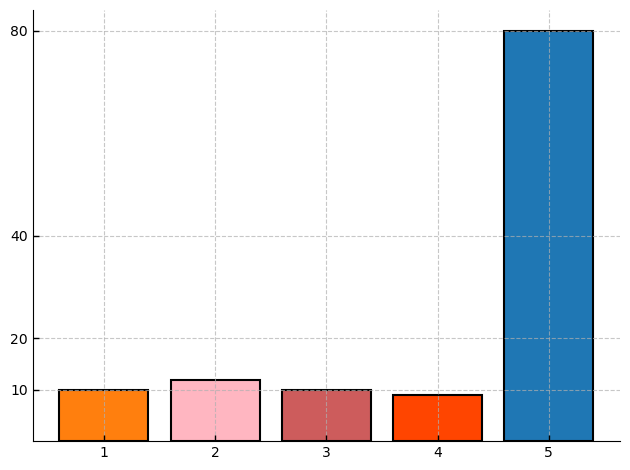

In [191]:
ALL_Peaks = np.load("ALL_Peaks_100.npy")
arr = ALL_Peaks
unique_elements, counts = np.unique(arr, return_counts=True)
hist, edges = np.histogram(counts, bins=[1, 2, 3, 4, 5, 6])

# 设置颜色
colors = [[1,127/255,14/255],[1.0, 0.713, 0.757],[0.804, 0.361, 0.361],[1.0, 0.271, 0.0],[31/255,119/255,180/255] ]
# 创建柱状图并设置颜色
plt.bar([1, 2, 3, 4, 5], hist, color=colors, edgecolor='black', linewidth=1.5)

# 取消右上角边框
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_xticks([1,2,3,4,5])
plt.gca().set_yticks([10,20,40,80])

# plt.gca().yaxis.set_ticklabels([])
# plt.gca().xaxis.set_ticklabels([])
# 在每个柱子上显示数值
# for i, v in enumerate(hist):
#     plt.text(i + 1, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)



# 显示刻度线
plt.tick_params(axis='both', which='both', direction='in', length=4, width=1, color='black')

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 调整图表的边距和布局
plt.tight_layout()

# 显示图表
plt.savefig('Template/pic/colorectal/hist.png',bbox_inches='tight',dpi=1000)

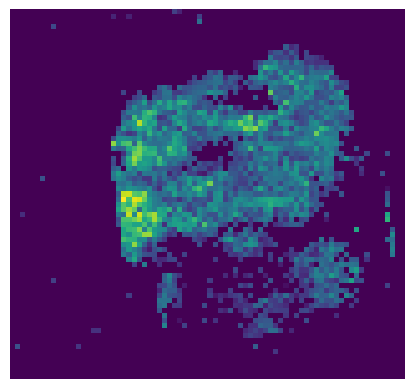

m/z Peak =  720.4954669548224


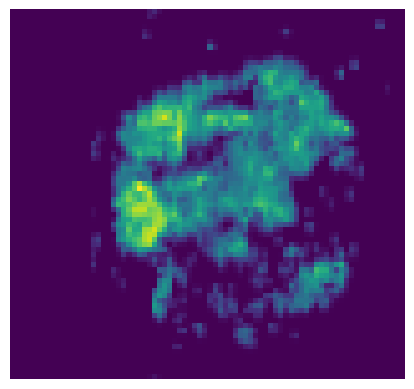

m/z Peak =  720.4954669548224


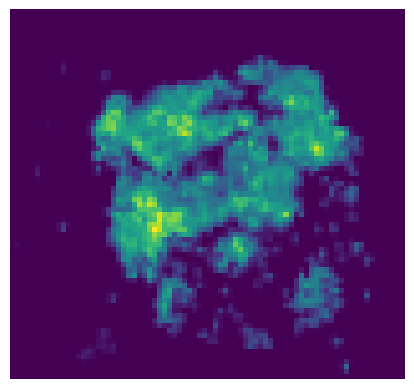

m/z Peak =  720.4954669548224


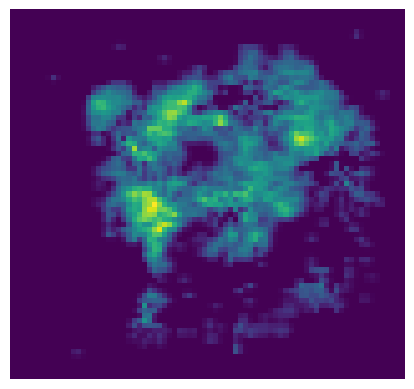

m/z Peak =  720.4954669548224


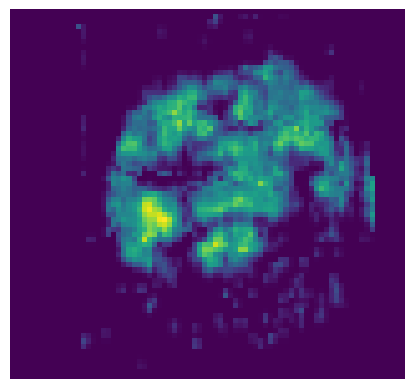

m/z Peak =  720.4954669548224


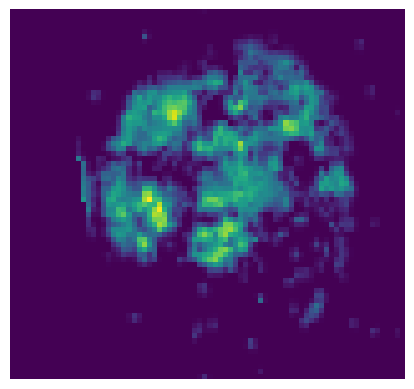

m/z Peak =  720.4954669548224


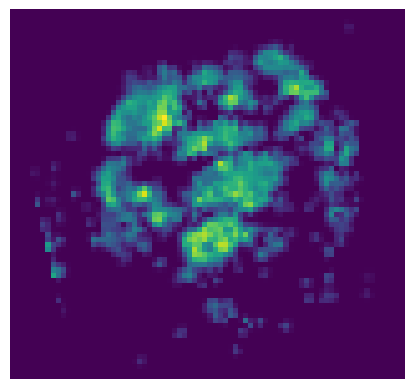

m/z Peak =  720.4954669548224


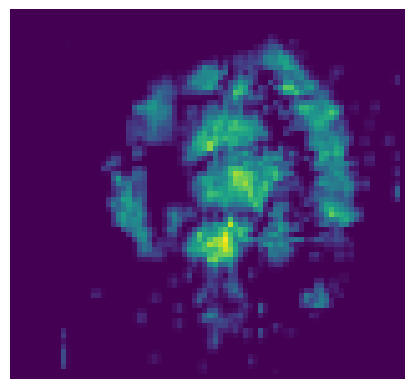

m/z Peak =  720.4954669548224


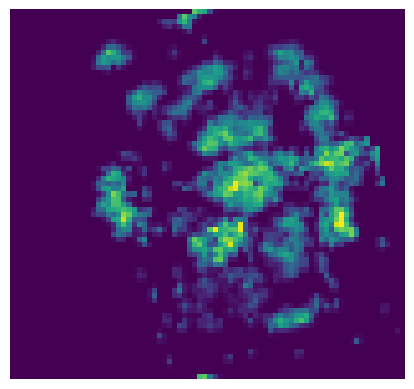

m/z Peak =  720.4954669548224


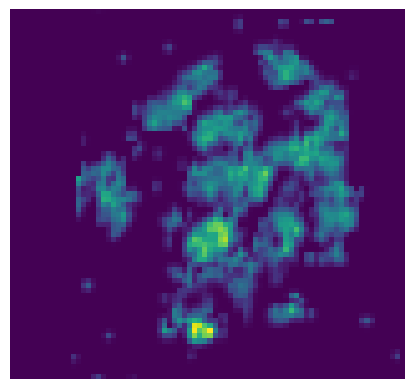

m/z Peak =  720.4954669548224


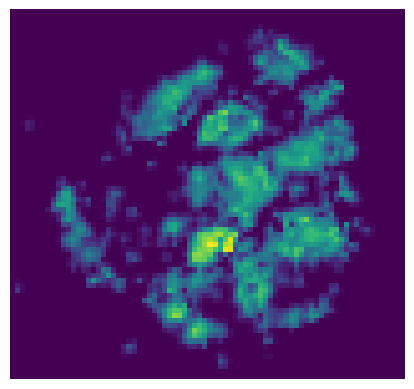

m/z Peak =  720.4954669548224


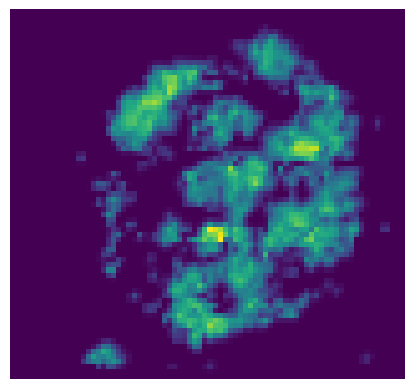

m/z Peak =  720.4954669548224


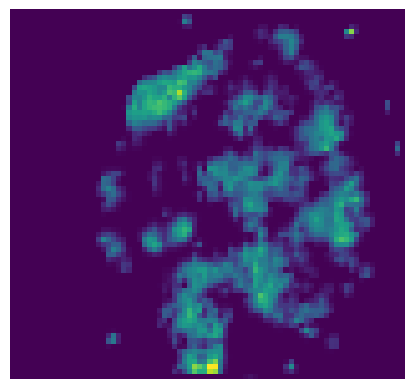

m/z Peak =  720.4954669548224


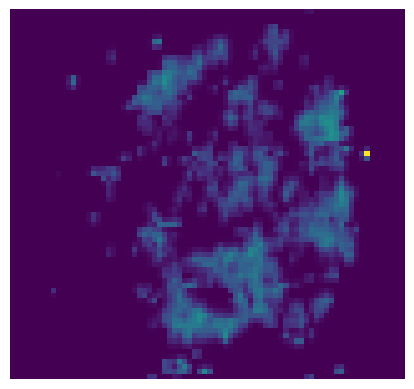

m/z Peak =  720.4954669548224


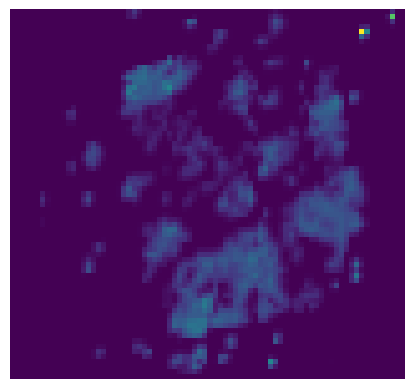

m/z Peak =  720.4954669548224


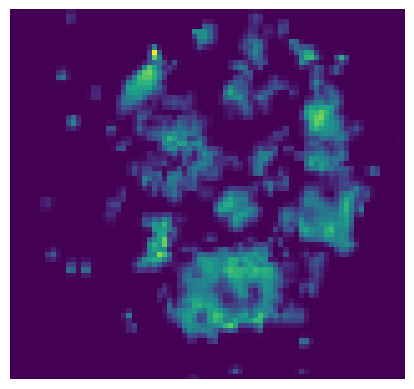

m/z Peak =  720.4954669548224


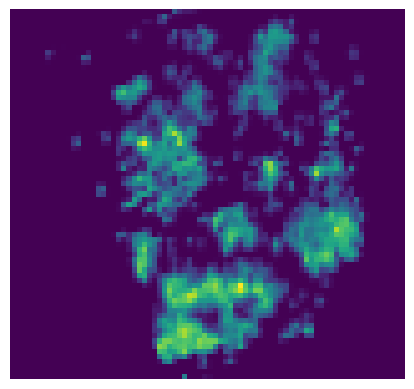

m/z Peak =  720.4954669548224


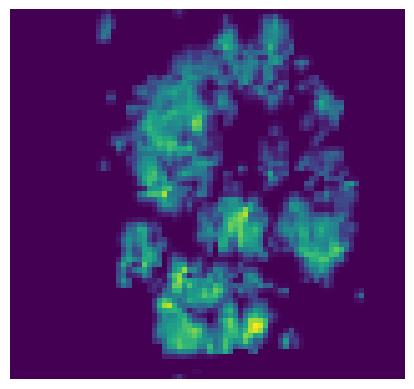

m/z Peak =  720.4954669548224


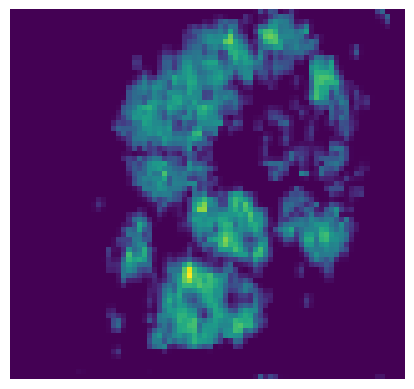

m/z Peak =  720.4954669548224


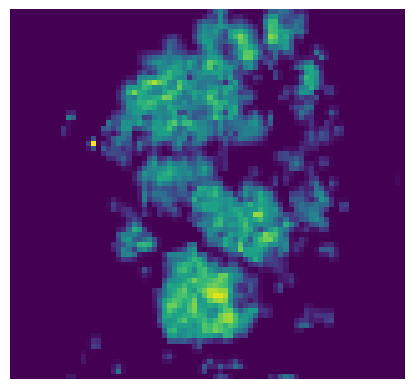

m/z Peak =  720.4954669548224


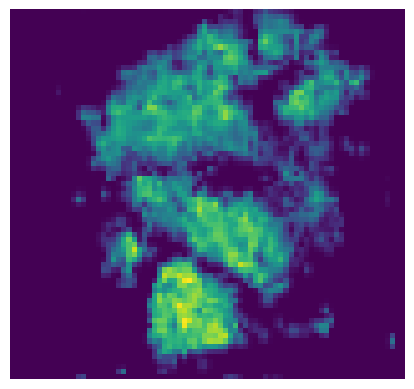

m/z Peak =  720.4954669548224


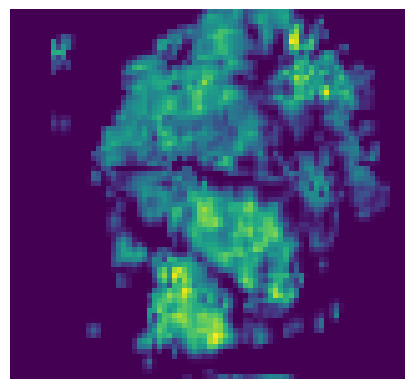

m/z Peak =  720.4954669548224


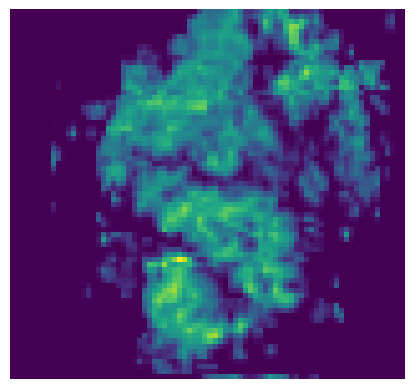

m/z Peak =  720.4954669548224


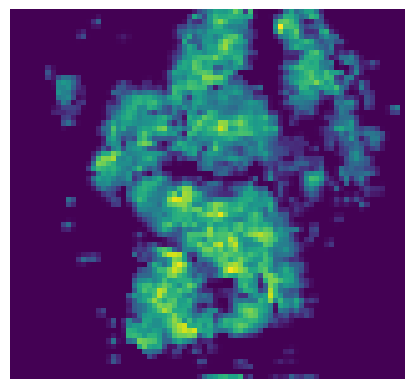

m/z Peak =  720.4954669548224


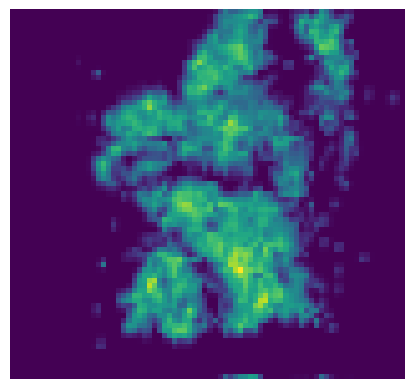

m/z Peak =  720.4954669548224


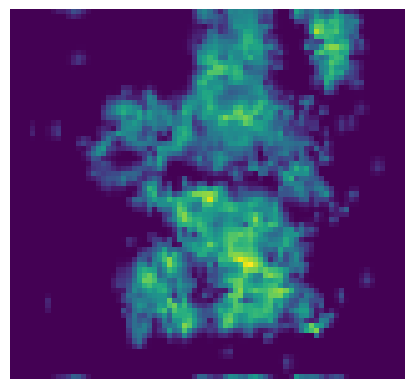

m/z Peak =  720.4954669548224


In [25]:
for section_id in myzSections:
    ij_r = np.argwhere(Z == section_id)
    indx = ij_r[0,:]
    xLoc = X[indx]
    yLoc = Y[indx]
    MSI_2D = np.squeeze(Combined_MSI_Shuffle[indx,mzID])
    im_mz = Image_Distribution_row_col(MSI_2D,xLoc,yLoc,col,row);
    plt.imshow(im_mz);plt.axis('off');
    plt.show()
    mz_Peak = Learned_mzPeaks[mzID]
    print('m/z Peak = ',mz_Peak)
    plt.imsave('achemso/pic/coloractal/' + 's'+str(section_id+1)+ '_tumor.png',im_mz) 

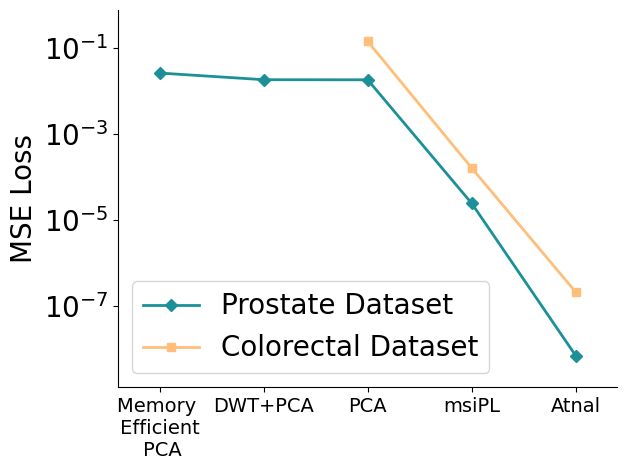

In [5]:
import matplotlib.pyplot as plt
import numpy as np

Prostate_loss = [2.585e-2, 1.81e-2, 1.8e-2, 2.42e-5, 7e-9]
Coolorectal_loss = [1.4e-1, 1.6e-4, 2.1e-7]

  # 调整图的大小

plt.plot([1,2,3,4,5], Prostate_loss, label="Prostate Dataset", marker='D', color='#1c9099', lw=2)
plt.yscale('log')

plt.plot([3, 4, 5], Coolorectal_loss, label="Colorectal Dataset", marker='s', color='#FFBE7A', lw=2)
plt.yscale('log')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=20)
plt.xticks([1,2,3,4,5] )
ax.set_xticklabels(['Memory \n Efficient \n PCA', 'DWT+PCA', 'PCA', 'msiPL', 'Atnal'] 
                   , fontsize=14)
#plt.xlabel('Methods', fontsize=16)
plt.ylabel('MSE Loss', fontsize=20)
plt.legend(fontsize=20)

plt.tight_layout()
plt.margins(0.1, 0.1)
# plt.show()

#yellow line
#plt.axvline(x=7, ymin=0, ymax=0.8,linestyle='dashed', color=[1.0, 0.824, 0.565, 1.0],linewidth=3)

# #m/z value when x=0             
# plt.annotate('m/z value 720.4954',
#              fontsize=15,
#              xy=(0, 0.78424842),   # 注释框所指向的坐标点
#              xytext=(2, 0.78424842+0.02),  # 注释文本的位置
#              arrowprops=dict(arrowstyle='->',linewidth=3,color=  [0.0, 0.0, 0.4, 1.0]))  # 箭头样式
# plt.annotate('m/z value 279.2335',
#              fontsize=15,
#              xy=(0, 0.7597526),   # 注释框所指向的坐标点
#              xytext=(2, 0.78424842-0.005),  # 注释文本的位置
#              arrowprops=dict(arrowstyle='->',linewidth=3,color=[0.0, 0.4, 0.0, 1.0]))  # 箭头样式
# # plt.show()
plt.savefig('achemso/pic/loss.pdf',format="pdf",bbox_inches='tight',dpi=1000)

In [14]:
zr=4

#compute a layer
cluster_id=[0,0]

cluster_id[0] = 3
cluster_id[1] = 4
mode='Train'
if mode=='Train':
    Labels=train_label
    X=X_train
    Y=Y_train
    Z=Z_train
elif mode=="Test":
    Labels=test_label
    X=X_test
    Y=Y_test
    Z=Z_test
else: 
    raise TypeError

myzSections = np.unique(Z) 
directory_result ='Results_CV//Section'+str(myzSections[zr])
if not os.path.exists(directory_result):
    os.makedirs(directory_result)

ij_r = np.argwhere(Z.detach().numpy() == myzSections[zr])
indx = ij_r[:,0]
Kimg=[0,0]
Kimg[0] = Labels[indx]==cluster_id[0]
Kimg[0] = Kimg[0].astype(int)
Kimg[1] = Labels[indx]==cluster_id[1]
Kimg[1] = 2*(Kimg[1].astype(int))
Kimg_all=Kimg[0]+Kimg[1]
print("section :",myzSections[zr])
f=h5py.File('./data/Colorectal_Adenocarcinoma.h5','r')
plt.imshow(np.array(f['data']['s'+str(myzSections[zr]+1)]['op']).transpose(1,2,0))
plt.imsave(directory_result + '//op' +  '.png',np.array(f['data']['s'+str(myzSections[zr]+1)]['op']).transpose(1,2,0))  
plt.axis('off')
plt.show()
f.close()

plt.imshow(Image_Distribution(Kimg_all,X[indx],Y[indx]))
plt.axis('off')
plt.show()
# plt.imsave(directory_result + '//clusters '+'.png',Image_Distribution(Labels[indx],X[indx],Y[indx]))  
# plt.imsave(directory_result + '//cluster'+str(cluster_id[0])+ str(cluster_id[1])+ '.png',Image_Distribution(Kimg_all,X[indx],Y[indx]))  



NameError: name 'test_label' is not defined

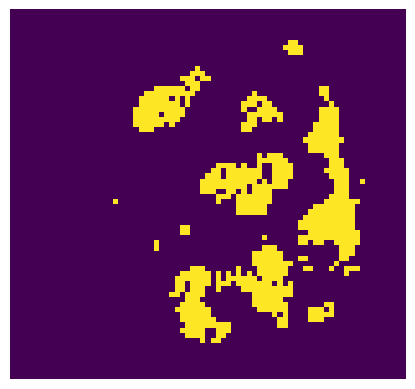

m/z [280.23357012 720.49546695 279.2335774  308.26366619 740.52552122
 310.28365149 741.52561395 307.26367346 833.51594466 745.6556839
 881.54619522 858.5260627  743.54559925 254.22345936 282.25355542]
corr_Value =  [0.73473451 0.72304605 0.71803025 0.7157357  0.71312075 0.70920361
 0.70365505 0.69649434 0.69337649 0.69268803 0.69063713 0.68244828
 0.68155335 0.68149603 0.6807334 ]


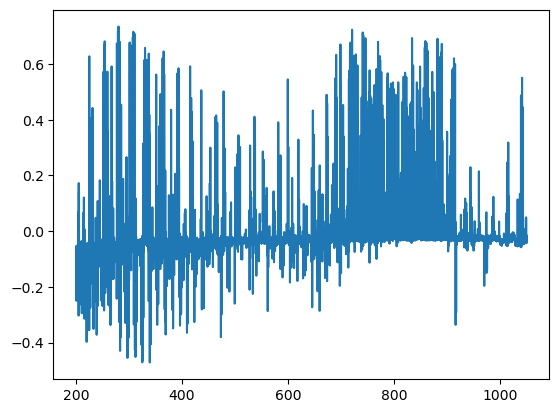

m/z Peak =  280.2335701210248


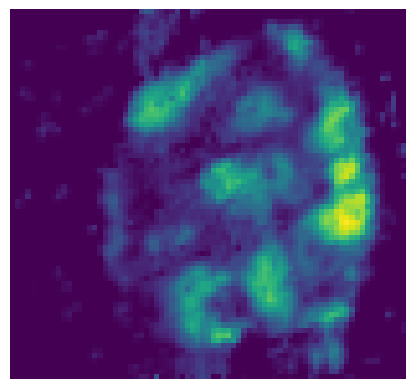

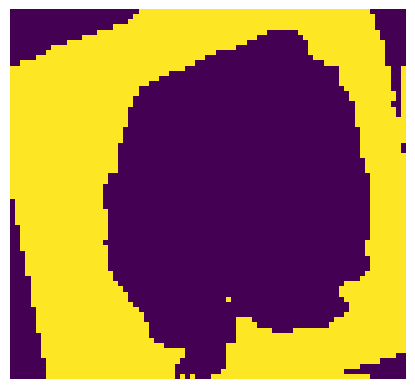

m/z [255.23345201 223.02338636 256.23344474 367.24393707 233.15331266
 227.10335667 284.2635408  699.65541858 395.26403321 291.0535914
 283.25354815 211.03327359 221.05330069 915.59634748 697.63533328]
corr_Value =  [0.59567687 0.58689732 0.57300125 0.56846691 0.55192352 0.54731744
 0.53997233 0.52856661 0.49298018 0.44385907 0.43781608 0.43101648
 0.42401987 0.40613067 0.40256279]


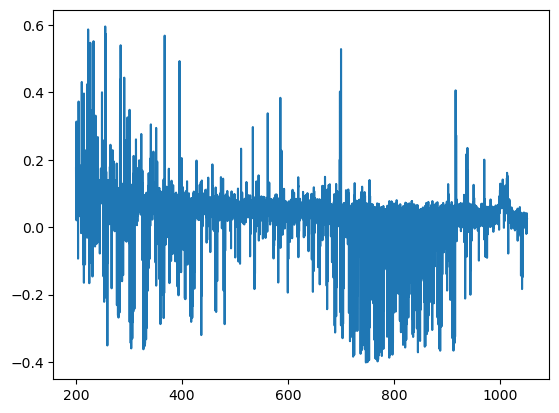

m/z Peak =  255.23345201169934


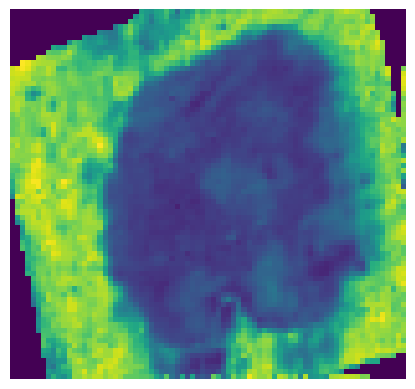

In [11]:
for i in range(2):
    plt.figure()
    plt.imshow(Image_Distribution(Kimg[i],X[indx],Y[indx]))
    plt.axis('off')
    plt.show()
    Real_PeakIdx=np.arange(len(mzList))
    Learned_mzPeaks=mzList
    Corr_Val, CorrRank_ij,MSI_CleanPeaks =  \
    Correlate_Cluster_MSI(cluster_id[i],Labels,Data_test,Real_PeakIdx,Z,X,Y)
    print('m/z', Learned_mzPeaks[CorrRank_ij[0:15]])
    print('corr_Value = ', Corr_Val[CorrRank_ij[0:15]])
    plt.plot(Learned_mzPeaks,Corr_Val)
    plt.show()

    mzID = CorrRank_ij[0];
    myzSections = np.unique(Z)   
    ij_r = np.argwhere(Z == myzSections[zr])
    indx = ij_r[0,:]
    xLoc = X[indx]
    yLoc = Y[indx]
    MSI_2D = np.squeeze(Data_test[indx,mzID])
    im_mz = Image_Distribution(MSI_2D,xLoc,yLoc);
    plt.imshow(im_mz);plt.axis('off');
    mz_Peak = Learned_mzPeaks[mzID]
    print('m/z Peak = ',mz_Peak)
    #plt.imsave(directory_result + '//cluster'+str(cluster_id[i])+ '.png',im_mz)  




In [12]:

# ============ Get 3D m/z image =================
mzValue = 13972.1
mzId = np.argmin(np.abs(mzList[:] - mzValue))
Get_3Dmz_nifti(Combined_MSI[:,mzId],mzValue,XCoord,YCoord,ZCoord,directory)
